# <font color='blue'> PPHA 30546 Machine Learning | Mini Project 3 </font> 

Kathy Zhang & Yimeng Wu

## 1. Overview

It is early in July of 2020, and you have just been hired to work for the Centers for Disease Control and Prevention (CDC).2 As you probably know, the CDC is a national health protection agency tasked with protecting public health and safety by preventing and mitigating disease, injury, and disability in both the United States (US) and abroad. According to their website the CDC “conducts critical science and provides health information that protects our nation against expensive and dangerous health threats.” 

The number of COVID-19 deaths in the US has just surpassed 100,000. Things are looking grim around the world, but hope is on the way in the form of several potential vaccines. Your team at the CDC has been tasked with optimizing the distribution of a future vaccine to the places in the US that are most in need. To aid in doing so, you need a good prediction of which communities will be the most hard-hit when the vaccine is ready.

You colleagues have asked you to develop a model that predicts COVID-19 deaths per capita using socio-economic, health, and weather/pollution data from any and all available sources. Predictions based on your analysis will help shape your office’s recommendations about how to best deploy limited vaccines. The project has two parts: understanding the available data and performing data analysis and answering questions.

In [106]:
# Import the libraries
import numpy as np
import pandas as pd
import openpyxl
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoLarsIC 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, KFold

from sympy import symbols, Eq, solve, exp
from IPython.display import Image
from IPython.core.display import HTML 

import warnings
warnings.filterwarnings('ignore')

## 2. Understanding the Data

### The full dataset is available for download from Canvas, but you should familiarize yourself with how it was constructed. The data was compiled from the following sources:

### 1. NY Times: Daily data on COVID-19 cases and deaths at the county level comes from the New York Times GitHub Repository. Cumulative cases and deaths were calculated for coun- ties in the continental United States as of July 1, 2020.3
### 2. Opportunity Insights: County characteristics, including baseline health measures, come from Bergeron, Chetty, Cutler, Scuderi, Stepner, and Turner (2016). The data are available for download on the Opportunity Insights Data Library webpage.4
### 3. PM COVID: Annual, county-level data on air pollution (PM2.5) and weather (average winter/summer temperature and relative humidity), and baseline mortality come from Wu, Nethery, Sabath, Braun, and Dominici (2020). The pollution and weather measures used in this project are calculated by averaging across annual averages from 2000-2016

## 3 Data Analysis

### 1. The “Variable Description.xlsx” spreadsheet contains a list of variables that we’ll use for our analyses. Note that this is not a full list of all the variables in the dataset, although it’s close (we are ignoring a few perfectly co-linear predictors). Filter the full set of variables in the dataset down to the the Opportunity Insights and PM COVID variables listed in the spreadsheet along with county, state, and deathspc.

In [107]:
# Read in the variable description data
var_des = pd.read_excel('PPHA_30546_MP03-Variable_Description.xlsx')
print(var_des.shape)
var_des.head()

(62, 4)


,Count,Variable,Description,Source
0,1,casespc,"COVID-19 Cases per 100,000 Population",NY Times
1,2,deathspc,"COVID-19 Deaths per 100,000 Population",NY Times
2,3,intersects_msa,Urban Area,Opportunity Insights
3,4,cur_smoke_q1,BRFSS: Fraction Current Smokers in Q1,Opportunity Insights
4,5,cur_smoke_q2,BRFSS: Fraction Current Smokers in Q2,Opportunity Insights


In [108]:
# Read in the covid data
covid = pd.read_csv('Data-Covid002.csv', encoding_errors= 'replace')
print(covid.shape)
covid.head()

(3107, 93)


,county,state,fips,cases,deaths,population,casespc,deathspc,cty,county_name,...,taxrate,tax_st_diff_top20,summer_tmmx,summer_rmax,winter_tmmx,winter_rmax,pm25,bmdeaths,bmcruderate,pm25_mia
0,Autauga,Alabama,1001,4434,152,918492,482.74780,16.548864,1001,Autauga,...,0.011183,0.0,306.02344,96.055420,288.08508,85.651848,11.712587,7893,859.29999,0
1,Baldwin,Alabama,1003,10465,278,3102984,337.25601,8.959118,1003,Baldwin,...,0.011756,0.0,305.51663,97.971542,290.20886,89.730972,10.077723,30292,976.20001,0
2,Barbour,Alabama,1005,3157,33,499262,632.33331,6.609756,1005,Barbour,...,0.012059,0.0,306.06226,97.371674,289.24210,88.633575,10.981967,5197,1040.90000,0
3,Bibb,Alabama,1007,2291,24,397470,576.39569,6.038192,1007,Bibb,...,0.008007,0.0,305.98218,96.293076,287.36282,86.485870,11.998714,4089,1028.80000,0
4,Blount,Alabama,1009,2082,15,997531,208.71532,1.503713,1009,Blount,...,0.007012,0.0,305.17886,94.630951,285.56567,85.449142,11.793022,9912,993.70001,0


In [109]:
# Filter columns
filtered_variables = var_des[var_des['Source'].isin(['Opportunity Insights', 'PM_COVID'])].loc[:,'Variable'].tolist()
filtered_variables = ['county', 'state', 'deathspc'] + filtered_variables

# Apply filter
covid = covid.filter(items=filtered_variables)

In [110]:
print(covid.shape)  # effectively removes 30 columns
covid.head()

(3107, 63)


,county,state,deathspc,intersects_msa,cur_smoke_q1,cur_smoke_q2,cur_smoke_q3,cur_smoke_q4,bmi_obese_q1,bmi_obese_q2,...,subcty_exp_pc,taxrate,tax_st_diff_top20,pm25,pm25_mia,summer_tmmx,summer_rmax,winter_tmmx,winter_rmax,bmcruderate
0,Autauga,Alabama,16.548864,1,0.333333,0.238095,0.208333,0.133333,0.375000,0.238095,...,1059.66930,0.011183,0.0,11.712587,0,306.02344,96.055420,288.08508,85.651848,859.29999
1,Baldwin,Alabama,8.959118,1,0.268097,0.233503,0.167464,0.176991,0.298050,0.262467,...,2209.91040,0.011756,0.0,10.077723,0,305.51663,97.971542,290.20886,89.730972,976.20001
2,Barbour,Alabama,6.609756,0,0.228571,0.250000,0.181818,0.111111,0.294118,0.571429,...,1570.24830,0.012059,0.0,10.981967,0,306.06226,97.371674,289.24210,88.633575,1040.90000
3,Bibb,Alabama,6.038192,1,0.244444,0.280000,0.181818,0.150000,0.466667,0.375000,...,1338.44120,0.008007,0.0,11.998714,0,305.98218,96.293076,287.36282,86.485870,1028.80000
4,Blount,Alabama,1.503713,1,0.304348,0.260870,0.352941,0.166667,0.347826,0.318182,...,987.43884,0.007012,0.0,11.793022,0,305.17886,94.630951,285.56567,85.449142,993.70001


In [111]:
covid.dtypes

county             object
state              object
deathspc          float64
intersects_msa      int64
cur_smoke_q1      float64
                   ...   
summer_tmmx       float64
summer_rmax       float64
winter_tmmx       float64
winter_rmax       float64
bmcruderate       float64
Length: 63, dtype: object

### 2. Compute and report descriptive (summary) statistics for the subset of Opportunity Insights and PM COVID variables you filtered in previous question.

In [112]:
covid.describe()  # add deathspc in since it is also numeric

,deathspc,intersects_msa,cur_smoke_q1,cur_smoke_q2,cur_smoke_q3,cur_smoke_q4,bmi_obese_q1,bmi_obese_q2,bmi_obese_q3,bmi_obese_q4,...,subcty_exp_pc,taxrate,tax_st_diff_top20,pm25,pm25_mia,summer_tmmx,summer_rmax,winter_tmmx,winter_rmax,bmcruderate
count,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,...,3107.000000,3107.000000,3106.000000,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,3107.000000,3107.00000
mean,23.790131,0.596717,0.212659,0.171048,0.134467,0.098316,0.239166,0.214580,0.209621,0.186739,...,2119.407531,0.023089,0.775634,8.371871,0.003540,303.126997,88.970517,280.404875,87.469432,1029.15597
std,67.852145,0.490636,0.149348,0.128130,0.132181,0.110110,0.165928,0.153237,0.175849,0.167227,...,999.833466,0.013848,1.470989,2.565927,0.059405,3.173950,9.689271,6.597855,4.811207,248.38181
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,290.455540,31.643282,264.693820,58.159798,189.30000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080128,0.000000,0.000000,0.000000,...,1510.192750,0.014993,0.000000,6.309710,0.000000,300.848035,88.052494,275.113020,85.093342,864.29999
50%,3.802303,1.000000,0.250000,0.198718,0.142857,0.096535,0.272076,0.241590,0.223124,0.194118,...,1935.919400,0.020339,0.000000,8.784647,0.000000,303.290440,91.320313,280.154690,88.028793,1036.30000
75%,21.461759,1.000000,0.310931,0.250000,0.200000,0.148719,0.335532,0.304348,0.297220,0.266667,...,2505.411100,0.027164,1.000000,10.483764,0.000000,305.817430,94.812389,285.543750,90.747704,1194.10000
max,2279.610600,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,20541.918000,0.209907,7.220000,15.786018,1.000000,313.872680,99.778748,298.340360,97.672874,1978.60000


In [113]:
# Print the states and number of states before droping missing values
print(set(covid['state']))
print(len(set(covid['state'])))

{'Vermont', 'Idaho', 'Michigan', 'Massachusetts', 'California', 'Maine', 'Oklahoma', 'Iowa', 'Arizona', 'Indiana', 'New Mexico', 'Tennessee', 'Minnesota', 'Connecticut', 'Delaware', 'Virginia', 'Arkansas', 'Colorado', 'New Jersey', 'Mississippi', 'Illinois', 'Louisiana', 'New Hampshire', 'New York', 'Wyoming', 'Florida', 'Ohio', 'South Carolina', 'Alabama', 'Texas', 'Utah', 'Missouri', 'Nevada', 'Kansas', 'Rhode Island', 'North Carolina', 'Maryland', 'Georgia', 'North Dakota', 'Wisconsin', 'Kentucky', 'Montana', 'Washington', 'South Dakota', 'Pennsylvania', 'District of Columbia', 'West Virginia', 'Nebraska', 'Oregon'}
49


### 3. Note that some variables have missing values. This causes problems when estimating the models. Normally we’d impute missing values, but to keep things simple, given the size of our data, you should drop all observations (rows) with missing values.


In [114]:
# Check for NA values
na_count = pd.DataFrame(np.sum(covid.isna(), axis = 0), columns = ["Count NAs"])
print(na_count)

                Count NAs
county                  0
state                   0
deathspc                0
intersects_msa          0
cur_smoke_q1            0
...                   ...
summer_tmmx             0
summer_rmax             0
winter_tmmx             0
winter_rmax             0
bmcruderate             0

[63 rows x 1 columns]


In [115]:
# Drop NAs
covid = covid.dropna()
print(covid.shape)

(2915, 63)


### 4. Create a separate dummy variable for each of the 48 states and the District of Columbia in the dataset (so you’ll create 49 dummy variables in total, but dropping observations with missing values may reduce this number).


In [116]:
# Print the states and number of states after droping missing values
print(set(covid['state']))
print(len(set(covid['state'])))  # we lost 2 states after droping missing values

{'Vermont', 'Idaho', 'Michigan', 'Massachusetts', 'California', 'Maine', 'Oklahoma', 'Iowa', 'Arizona', 'Indiana', 'New Mexico', 'Tennessee', 'Minnesota', 'Connecticut', 'Delaware', 'Virginia', 'Arkansas', 'Colorado', 'Mississippi', 'Illinois', 'Louisiana', 'New Hampshire', 'New York', 'Wyoming', 'Florida', 'Ohio', 'South Carolina', 'Alabama', 'Texas', 'Utah', 'Missouri', 'Nevada', 'Kansas', 'Rhode Island', 'North Carolina', 'Maryland', 'Georgia', 'North Dakota', 'Wisconsin', 'Kentucky', 'Montana', 'Washington', 'South Dakota', 'Pennsylvania', 'West Virginia', 'Nebraska', 'Oregon'}
47


In [117]:
covid_new = pd.get_dummies(covid, columns = ['state'])
covid_new.head()

,county,deathspc,intersects_msa,cur_smoke_q1,cur_smoke_q2,cur_smoke_q3,cur_smoke_q4,bmi_obese_q1,bmi_obese_q2,bmi_obese_q3,...,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
0,Autauga,16.548864,1,0.333333,0.238095,0.208333,0.133333,0.375000,0.238095,0.260870,...,False,False,False,False,False,False,False,False,False,False
1,Baldwin,8.959118,1,0.268097,0.233503,0.167464,0.176991,0.298050,0.262467,0.193237,...,False,False,False,False,False,False,False,False,False,False
2,Barbour,6.609756,0,0.228571,0.250000,0.181818,0.111111,0.294118,0.571429,0.545455,...,False,False,False,False,False,False,False,False,False,False
3,Bibb,6.038192,1,0.244444,0.280000,0.181818,0.150000,0.466667,0.375000,0.190476,...,False,False,False,False,False,False,False,False,False,False
4,Blount,1.503713,1,0.304348,0.260870,0.352941,0.166667,0.347826,0.318182,0.529412,...,False,False,False,False,False,False,False,False,False,False


### 5. Split the sample into a training set (80%) and a test set (20%). Be sure to set a random state so you can replicate your work. There are odd patterns in the results with some splits of the data, so to avoid confusion and facilitate grading, please set random_state=11.

In [118]:
# Define X, y and test, training sets
X = covid_new.copy()
X = X.drop(['county'], axis=1)
y = X.pop('deathspc') 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

### 6. Using the training set, fit a model of COVID-19 deaths per capita (y =deathspc) as a function of the Opportunity Insights and PM COVID predictors listed in the spreadsheet, as well as state-level fixed effects (the state dummy variables) using OLS.
### (a) Using the model you fit, calculate and report the MSE in both the training and test sets.


<font color='blue'> Training set MSE is 1440.7, and test set MSE is 2408.75. 

In [119]:
ols = LinearRegression().fit(X_train, y_train)

In [120]:
print('Coefficients:', ols.coef_)
print('Intercept:', ols.intercept_)

Coefficients: [ 2.37702564e+00 -1.03471715e+01 -1.61148248e+01  4.67713593e+00
  7.46622702e-02 -1.58893213e+00  1.34545068e+01 -1.72708563e+01
  6.36324857e+00 -9.38672528e+00  6.85699486e+00  3.37188762e+00
 -2.51138257e+00 -7.27164148e+00  4.14098624e-02 -9.30073703e-04
  5.94541681e-01  2.11075403e+00 -1.71365314e+01  9.11057620e+00
 -2.80134636e-01 -8.49686889e-01 -9.26122723e-02 -3.73950393e-01
  2.25634841e-02  7.54010877e+02 -5.15841419e+02 -2.24027029e+02
  1.06511716e-01 -4.22160985e+01  3.20079680e+01 -1.59458593e+01
 -5.95117337e+01 -5.40874454e+00  1.34324468e-01  6.76379157e-01
 -1.45762130e-01 -2.41393005e+02 -5.31091177e+01  4.53444740e+01
  1.03909357e+00 -9.85661503e+00 -2.24869965e+02  1.01949088e-02
 -1.80329786e+01  7.52128985e-04 -1.00579775e-05  1.34950098e+00
  2.46993959e-01  2.92115799e+01 -6.42863930e-04 -9.42957664e+01
 -7.93339858e-01 -5.01525805e-01 -1.29624203e+01 -5.13678437e-01
 -7.68260713e-01  1.38200161e+00  5.53849066e-02 -2.72799877e-03
 -2.2905083

In [121]:
y_pred_train = ols.predict(X_train)
mse_train_ols = mean_squared_error(y_train, y_pred_train)
print("OLS-Train MSE: ", round(mse_train_ols,2))

OLS-Train MSE:  1440.7


In [122]:
y_pred_test = ols.predict(X_test)
mse_test_ols = mean_squared_error(y_test, y_pred_test)
print("OLS-Test MSE: ", round(mse_test_ols,2))

OLS-Test MSE:  2408.75


### (b) Why might you be concerned about overfitting in this context? Is there any evidence of overfitting? Briefly explain.

<font color='blue'> 

#### Concerns

- Complexity and dimentionality: The COVID-19 pandemic is influenced by a multitude of factors, and with the high dimensionality in this context, the complex interplay between these variables can lead to models that, while fitting the training data well, fail to generalize to unseen data or future scenarios as it captures noise in the training data,  which leads to unreasonable policy decisions. 

- Linear relationship: linear relationships are the easiest to interpret, but, with overfitting, some non-significant predictors can be falsely interpreted and used for policy.

- Time constraint: This is crucial because the progression of the pandemic is inherently time-dependent, with dynamics that can change rapidly due to new virus strains, changes in public behavior, and policy interventions. A model trained on data from a specific time period might overfit to the conditions of that period and not perform well as the situation evolves.


#### Evidence for overfitting

As observed from our plots of flexibility versus error from PSet1, an increase in flexibility consistently leads to a reduction in training error. This trend occurs because a model tailored to the training set becomes increasingly adept at capturing the specific nuances of that data. However, this trend does not necessarily extend to the testing set. Beyond a certain threshold, where the testing error reaches its minimum, further increases in flexibility lead to a rise in testing error. While bias tends to decrease with greater model flexibility, variance, and consequently, the testing error, tend to escalate.

A significant discrepancy between the model's performance on the training set and the test set might indicate overfitting given the huge gap between testing and training error--2408.75-1440.7 = 968.05. It suggests that the model performs well on the data it was trained on but poorly on unseen data, indicating that testing error may have past its minimum point for best bias and starts to surge as variance increases due to fitting these intricate patterns in the training data too closely. Intuitively, using 100+ variables, it is no wonder the model is prone to overfitted.

### 7. Use the training set to estimate ridge regression and the lasso analogs to the OLS model in the previous question. For each, you should report a plot of the cross-validation estimates of the test error as a function of the value of the hyperparameter (lambda) that indicates the tuned value of lambda. Hint: to do so you should be sure to scale your predictors. Then you should tune the hyperparameter by:

There are several ways to scale or normalize variables. Scaling here refers to transforming each predictor so that
the mean is 0 and the variance is 1. Similar to the discussion in a previous assignment, there is a trade-off between
scaling before splitting into training and test sets or after. The former uses more precise estimates of the population
mean and variance. The latter does not bring information from the test set into the training set (which could result in
inadvertent overfitting). Given the sample size in this question, you should scale after splitting your data.

In [123]:
# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

ridge = Ridge()

### (a) Calculating each model for a grid or range of values of lambda. You will want to adjust the values you search over based on what you learn in the subsequent steps, but start by using 100 values of lambda from 0.01 to 100.

Hint: to do so, start by creating a range of 100 numbers from −2 to 2. You can do that by starting at −2 and incriminating each subsequent number by 1/25 . Let a denote those values and b denote the values of the grid for tuning λ.You can calculate b = 10^a.

In [145]:
a = np.linspace(-2, 2, 100)
lambda_range = np.power(10, a)

In [125]:
def vector_values(grid_search, trials):
    '''
    Extracts mean and standard deviation scores from a GridSearchCV object.
    ​
    Parameters
    ----------
    grid_search : GridSearchCV object
    The result of a grid search performed using scikit-learn's GridSearchCV method.
    trials : int
    The number of trials performed during the grid search.
    ​
    Returns
    -------
    mean_vec : ndarray of shape (trials,)
    Array of mean scores, with the negative of each score stored in the array.
    std_vec : ndarray of shape (trials,)
    Array of standard deviation scores.
    '''
    mean_vec = np.zeros(trials)
    std_vec = np.zeros(trials)
    i = 0
    final = grid_search.cv_results_
    
    for mean_score, std_score in zip(final["mean_test_score"],
                                     final["std_test_score"]):
        mean_vec[i] = -mean_score
        std_vec[i] = std_score
        i = i+1
    return mean_vec, std_vec

In [126]:
def highlight_min(data, color='yellow'):
    attr = f'background-color: {color}'
    if data.ndim == 1:  # Series
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    return ''

### (b) Using 10-fold cross-validation (10FCV) (on the training data) to estimate the test error for each model at the given value of lambda. Use the KFold function to shuffle the data randomly for 10FCV. Please set random_state=25 when doing so.

### Ridge

In [146]:
# Creating a parameters grid
param_grid = [{'alpha': lambda_range}]

# Running Grid Search over the alpha (regularization) parameter
kf = KFold(n_splits=10, random_state = 25, shuffle=True)
grid_search_ridge = GridSearchCV(ridge, param_grid, cv=kf,
                                 scoring='neg_mean_squared_error')
grid_search_ridge.fit(X_train, y_train)

# Extract results for all tested alphas
tested_alphas_ridge = [params['alpha'] for params in grid_search_ridge.cv_results_['params']]

# Assuming vector_values is properly defined to extract mean and standard deviation values
mean_vec_ridge, std_vec_ridge = vector_values(grid_search_ridge, len(tested_alphas_ridge))
results_cv_ridge = pd.DataFrame({'alpha': tested_alphas_ridge,
                                 'MSE': mean_vec_ridge}) # 'standard deviation': std_vec_ridge


### Lasso

In [149]:
# Creating a parameters grid
param_grid = {'lasso__alpha': lambda_range}

# Creating a pipeline and GridSearchCV object
pipeline = make_pipeline(StandardScaler(), Lasso(random_state=25))
grid_search = GridSearchCV(pipeline, param_grid, cv=10,
                           scoring='neg_mean_squared_error')

# Fitting the GridSearchCV object
grid_search.fit(X_train, y_train)

# Extract results and convert 'mean_test_score' to positive values
# Note: the term mean_test_score refers to the average mean squared error (MSE) 
# across the cross-validation folds for each alpha value when using GridSearchCV.
results = pd.DataFrame(grid_search.cv_results_)
results['mean_test_score'] = -results['mean_test_score']

### (c) Plotting the 10FCV estimates of the test error as a function of the value of lambda.

### Ridge

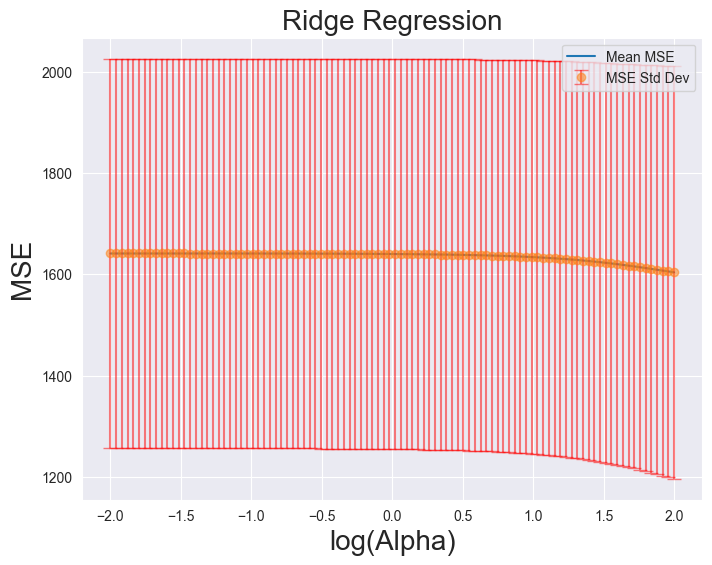

In [129]:
mean_vec, std_vec = vector_values(grid_search_ridge, len(tested_alphas_ridge))

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Ridge Regression', fontsize=20)
log_alpha_param = np.log10(lambda_range) # log transform to aid with interpretability of axis
ax.plot(log_alpha_param, mean_vec, label='Mean MSE')
ax.errorbar(log_alpha_param, mean_vec, yerr=std_vec, fmt='o', ecolor='r',
            capsize=5, alpha=0.5, label='MSE Std Dev')
ax.set_ylabel("MSE", fontsize=20)
ax.set_xlabel("log(Alpha)", fontsize=20)
plt.legend()
plt.show()

### Lasso

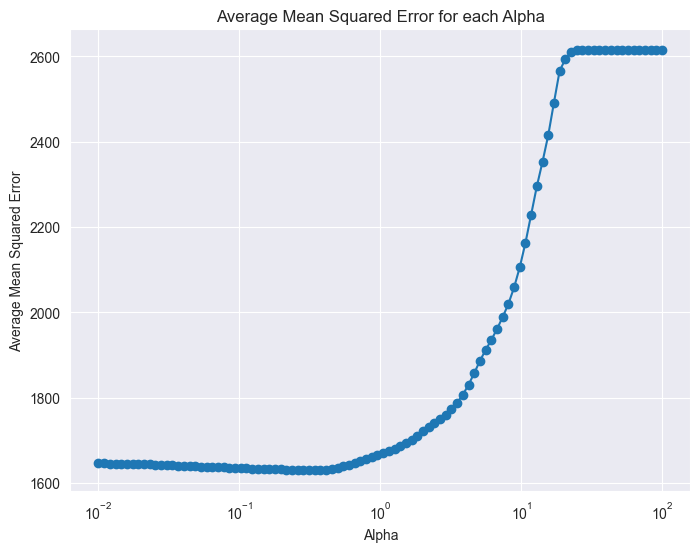

In [158]:
# Lasso
# Plotting mean test scores for each alpha value
plt.figure(figsize=(8, 6))
plt.semilogx(lambda_range, results['mean_test_score'], marker='o')
plt.xlabel('Alpha')
plt.ylabel('Average Mean Squared Error')
plt.title('Average Mean Squared Error for each Alpha')
plt.show()

### (d) Choosing the optimal value of lambda.

<font color='blue'> The optimal value of lambda for ridge is 100, which gives the best MSE possible of 1604.04. The optimal value of lambda for lasso is 0.343, which gives the best MSE possible of 1629.56. 

### Ridge

In [152]:
top_5_results_cv_ridge = results_cv_ridge.sort_values(by='MSE',
                                                      ascending=True).head(5)

styled_top_5 = top_5_results_cv_ridge.style.apply(highlight_min, subset=['MSE'])
display(styled_top_5)

,alpha,MSE
99,100.000000,1604.042283
98,91.116276,1605.705514
97,83.021757,1607.392388
96,75.646333,1609.085492
95,68.926121,1610.769758


In [141]:
# Getting the best alpha value and corresponding MSE
best_alpha = grid_search_ridge.best_params_['alpha']
best_mse = -grid_search_ridge.best_score_
print(f"Best alpha: {best_alpha}")
print(f"Best MSE: {best_mse}")

Best alpha: 100.0
Best MSE: 1604.0422830401026


### Lasso

In [154]:
# Lasso
# Applying the highlighting function only to 'mean_test_score' column
results_style = results[['params', 'mean_test_score']].style.apply(
    highlight_min, subset=['mean_test_score'])

results_style

,params,mean_test_score
0,{'lasso__alpha': 0.01},1645.888398
1,{'lasso__alpha': 0.010974987654930561},1645.702960
2,{'lasso__alpha': 0.012045035402587823},1645.499825
3,{'lasso__alpha': 0.013219411484660288},1645.282316
4,{'lasso__alpha': 0.014508287784959394},1645.052846
5,{'lasso__alpha': 0.015922827933410922},1644.806451
6,{'lasso__alpha': 0.01747528400007684},1644.545559
7,{'lasso__alpha': 0.019179102616724886},1644.194673
8,{'lasso__alpha': 0.02104904144512021},1643.772171
9,{'lasso__alpha': 0.023101297000831605},1643.317517


In [159]:
# Getting the best alpha value and corresponding MSE
best_lasso_alpha = grid_search.best_params_['lasso__alpha']
best_lasso_mse = grid_search.best_score_

print(f"Best alpha: {best_lasso_alpha}")
print(f"Best MSE: {-best_lasso_mse}")

Best alpha: 0.34304692863149194
Best MSE: 1629.5625708821492


### (e) Re-estimating your model on the full training set using that optimal value of lambda.

### Ridge

In [143]:
# Estimating using the optimal value of lambda
ridge = Ridge()
param_grid = [{
    'alpha': [best_alpha]
}]
kf = KFold(n_splits=10, random_state = 25, shuffle=True)
grid_search_ridge_best = GridSearchCV(ridge, param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search_ridge_best.fit(X_train, y_train)

print('ridge_alpha: ', best_alpha)
print('MSE: ', -grid_search_ridge_best.best_score_)

ridge_alpha:  100.0
MSE:  1604.0422830401026


### Lasso

In [160]:
# Creating a parameters grid
param_grid = {'lasso__alpha': [best_lasso_alpha]}

# Creating a pipeline and GridSearchCV object
pipeline = make_pipeline(StandardScaler(), Lasso(random_state=25))
grid_search_lasso_best = GridSearchCV(pipeline, param_grid, cv=10,
                           scoring='neg_mean_squared_error')

# Fitting the GridSearchCV object
grid_search_lasso_best.fit(X_train, y_train)

# Getting the best alpha value and corresponding MSE
best_lasso_alpha = grid_search_lasso_best.best_params_['lasso__alpha']
best_lasso_mse = grid_search_lasso_best.best_score_

print(f"Best alpha: {best_lasso_alpha}")
print(f"Best MSE: {-grid_search_lasso_best.best_score_}")

Best alpha: 0.34304692863149194
Best MSE: 1629.5625708821492


### 8. Using the ridge regression and the lasso models you trained based on the optimal values of lambda you found in the previous question, calculate and report the training and test set prediction errors (MSE) for each model. Did ridge regression and/or the lasso improve your prediction over OLS? Which model performs the best? Briefly explain which model you would recommend to the CDC and why.

<font color='blue'> 
Based on the calculations of MSE:

- Ridge Training MSE:  1640.8741227772055
- Ridge Testing MSE:  2849.6742293959796
- Lasso Training MSE:  1629.5625708821492
- Lasso Testing MSE:  2764.20520252161

Lasso trainig MSE < Ridge Training MSE < Lasso Testing MSE < Ridge Testing MSE, hence lasso gives the best prediction

In [162]:
# Ridge training
# Estimating using the optimal value of lambda
ridge = Ridge()
param_grid = [{'alpha': [best_alpha]}]
kf = KFold(n_splits=10, random_state = 25, shuffle=True)
grid_search_ridge_best = GridSearchCV(ridge, param_grid, cv=kf,
                                      scoring='neg_mean_squared_error')
grid_search_ridge_best.fit(X_train, y_train)

print('Ridge Training MSE: ', -grid_search_ridge_best.best_score_)

Ridge Training MSE:  1640.8741227772055


In [163]:
# Ridge testing
# Estimating using the optimal value of lambda
ridge = Ridge()
param_grid = [{'alpha': [best_alpha]}]
kf = KFold(n_splits=10, random_state = 25, shuffle=True)
grid_search_ridge_best = GridSearchCV(ridge, param_grid, cv=kf,
                                      scoring='neg_mean_squared_error')
grid_search_ridge_best.fit(X_test, y_test)

print('Ridge Testing MSE: ', -grid_search_ridge_best.best_score_)

Ridge Testing MSE:  2849.6742293959796


In [166]:
# Lasso training
# Creating a parameters grid
param_grid = {'lasso__alpha': [best_lasso_alpha]}

# Creating a pipeline and GridSearchCV object
pipeline = make_pipeline(StandardScaler(), Lasso(random_state=25))
grid_search_lasso_best = GridSearchCV(pipeline, param_grid, cv=10,
                           scoring='neg_mean_squared_error')
grid_search_lasso_best.fit(X_train, y_train)

print('Lasso Training MSE: ', -grid_search_lasso_best.best_score_)

Lasso Training MSE:  1629.5625708821492


In [165]:
# Lasso testing
# Creating a parameters grid
param_grid = {'lasso__alpha': [best_lasso_alpha]}

# Creating a pipeline and GridSearchCV object
pipeline = make_pipeline(StandardScaler(), Lasso(random_state=25))
grid_search_lasso_best = GridSearchCV(pipeline, param_grid, cv=10,
                           scoring='neg_mean_squared_error')
grid_search_lasso_best.fit(X_test, y_test)

print('Lasso Testing MSE: ', -grid_search_lasso_best.best_score_)

Lasso Testing MSE:  2764.20520252161
